# Introduction: Energy Star Score Part 2

In this series of notebooks, we are working on a supervised, regression machine learning problem. Using real-world New York City building energy data, we want to predict the Energy Star Score of a building and determine the factors that influence the score.

### Imports 

We will use the standard data science and machine learning libraries in this project. 

In [1]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

In [2]:
#!pip install scikit-learn==0.21.2

In [3]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Seaborn for visualization
import seaborn as sns
sns.set(style = 'whitegrid')

# Imputing missing values and scaling values
from sklearn.preprocessing import MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### Read in Data

First let's read in the formatted data from the previous notebook. 

In [4]:
# Read in data into dataframes 
#from google.colab import drive
#drive.mount('/gdrive')
train_features = pd.read_csv('training_features.csv')
test_features = pd.read_csv('testing_features.csv')
train_labels = pd.read_csv('training_labels.csv')
test_labels = pd.read_csv('testing_labels.csv')

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (6622, 63)
Testing Feature Size:   (2839, 63)
Training Labels Size:   (6622, 1)
Testing Labels Size:    (2839, 1)


As a reminder, here is what the formatted data looks like. In the first notebook, we engineered a number features by taking the natural log of the variables, included two categorical variables, and selected a subset of features by removing highly collinear features. 

In [5]:
train_features.head(12)

,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Water Intensity (All Water Sources) (gal/ft²),Latitude,Longitude,Community Board,Census Tract,log_Direct GHG Emissions (Metric Tons CO2e),log_Water Intensity (All Water Sources) (gal/ft²),Borough_Queens,Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,Largest Property Use Type_Mailing Center/Post Office,Largest Property Use Type_Manufacturing/Industrial Plant,Largest Property Use Type_Medical Office,Largest Property Use Type_Movie Theater,Largest Property Use Type_Multifamily Housing,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,90300.0,1950,1,100,126.0,5.2,1.2,99.41,NaN,NaN,NaN,NaN,6.088818,4.599253,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,52000.0,1926,1,100,95.4,4.7,0.9,NaN,40.835496,-73.887745,3.0,161.0,5.384036,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,104700.0,1954,1,100,40.4,3.8,0.3,NaN,40.663206,-73.949469,9.0,329.0,5.017280,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,129333.0,1992,1,100,157.1,16.9,1.1,NaN,40.622968,-74.078742,1.0,27.0,6.510853,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,109896.0,1927,1,100,62.3,3.5,0.0,28.65,40.782421,-73.972622,7.0,165.0,6.123589,3.355153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,182655.0,1929,1,90,52.9,9.7,0.2,4.80,40.725136,-74.004438,2.0,37.0,5.516649,1.568616,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,65400.0,1942,1,100,66.8,3.0,0.6,67.14,40.637833,-73.973045,12.0,490.0,5.426271,4.206780,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,113150.0,1938,1,100,78.4,5.7,NaN,30.73,40.776035,-73.964418,8.0,142.0,6.067036,3

The `score` column contains the Energy Star Score, the target for our machine learning problem. The Energy Star Score is supposed to be a comparitive measurement of the energy efficiency of a building, although we saw there may be issues with how this is calculated in part one! 

Here's the distribution of the Energy Star Score.

Text(0.5, 1.0, 'ENERGY Star Score Distribution')

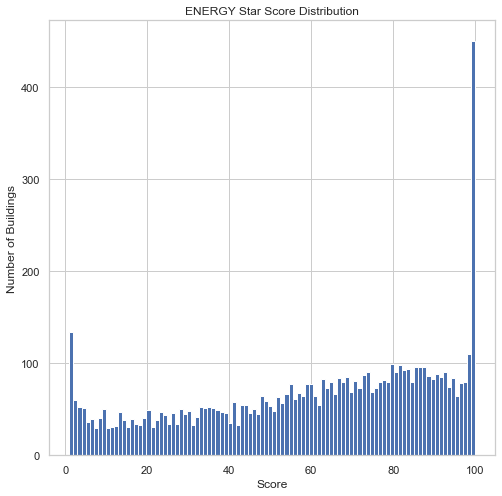

In [6]:
plt.figure(figsize = (8, 8))

# Histogram of the Energy Star Score
plt.hist(train_labels['score'].dropna(), bins = 100)
plt.xlabel('Score')
plt.ylabel('Number of Buildings')
plt.title('ENERGY Star Score Distribution')

# Evaluating and Comparing Machine Learning Models

In this section we will build, train, and evalute several machine learning methods for our supervised regression task. The objective is to determine which model holds the most promise for further development (such as hyperparameter tuning). 

We are comparing models using the __mean absolute error__. A baseline model that guessed the median value of the score was off by an __average of 25 points__. 

## Imputing Missing Values

Standard machine learning models cannot deal with missing values, and which means we have to find a way to fill these in or disard any features with missing values. Since we already removed features with more than 50% missing values in the first part, here we will focus on filling in these missing values, a process known as imputation. There are a number of methods for imputation but here we will use the relatively simple method of replacing missing values with the median of the column.

In the code below, we create a Scikit-learn `Imputer` object to fill in missing values with the median of the column. Notice that we train the imputer (using the `Imputer.fit` method) on the training data but not the testing data. We then transform (using `Imputer.transform`) both the training data and testing data. This means that the missing values in the testing set are filled in with the median value of the corresponding columns in the training set. We have to do it this wayrather than because at deployment time, we will have to impute the missing values in new observations based on the previous training data. This is one way to avoid the problem known as data leakage where information from the testing set "leaks" into the training process.

In [7]:
!pip install impyute

In [8]:
from impyute.imputation.cs import mice
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

In [9]:
imputer = IterativeImputer(GradientBoostingRegressor())
# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

C:\Users\staya\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [10]:
print('Missing values in training features: ', np.sum(np.isnan(X)))
print('Missing values in testing features:  ', np.sum(np.isnan(X_test)))

Missing values in training features:  0
Missing values in testing features:   0


### Scaling Features

The final step to take before we can build our models is to scale the features. This is necessary because features are in different units, and we want to normalize the features so the units do not affect the algorithm. Linear Regression and Random Forest do not require feature scaling, but other methods, such as support vector machines and k nearest neighbors, do require it because they take into account the Euclidean distance between observations. For this reason, it is a best practice to scale features when we are comparing multiple algorithms. 

There are two ways to scale features

1. For each value, subtract the mean of the feature and divide by the standard deviation of the feature. This is known as standardization and results in each feature having a mean of 0 and a standard deviation of 1.
2. For each value, subtract the minimum value of the feature and divide by the maximum minus the minimum for the feature (the range). This assures that all the values for a feature are between 0 and 1 and is called scaling to a range or normalization.

As with imputation, when we train the scaling object, we want to use only the training set. When we transform features, we will transform both the training set and the testing set.

In [12]:
# Create the scaler object with a range of 0-1
#scaler = MinMaxScaler(feature_range=(0, 1))
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [13]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

## Models to Evaluate

We will compare four different machine learning models using the great Scikit-Learn library:

1. Linear Regression
3. Random Forest Regression
4. Gradient Boosting Regression
5. K-Nearest Neighbors Regression

To compare the models, we are going to be mostly using the Scikit-Learn defaults for the model hyperparameters. Generally these will perform decently, but should be optimized before actually using a model. At first, we just want to determine the baseline performance of each model, and then we can select the best performing model for further optimization using hyperparameter tuning. Remember that the default hyperparameters will get a model up and running, but nearly always should be adjusted using some sort of search to find the best settings for your problem! 

One of the best parts about scikit-learn is that all models are implemented in an identical manner: once you know how to build one, you can implement an extremely diverse array of models. Here we will implement the entire training and testing procedures for a number of models in just a few lines of code.

In [14]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [16]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)
print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 13.3803


In [17]:
from sklearn.model_selection import cross_val_score
scoreslr = cross_val_score(lr, X, y, cv=10)
print("Linear Regression")
print(scoreslr)
#Bias Variance Error Calculation
print("Bias Error (1-Accuracy/R2)")
print(1-np.mean(scoreslr))
print("Variance Error")
print(np.var(scoreslr))

Linear Regression
[0.67358943 0.65936187 0.68678524 0.6914019  0.69265721 0.66173452
 0.57124359 0.69004482 0.61348576 0.67747799]
Bias Error (1-Accuracy/R2)
0.3382217674172463
Variance Error
0.001417593512588766


In [18]:
random_forest = RandomForestRegressor(n_estimators=2,random_state=42)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

Random Forest Regression Performance on the test set: MAE = 11.5379


In [19]:
gradient_boosted = GradientBoostingRegressor(random_state=42)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 9.9880


In [20]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 12.1691


Text(0.5, 1.0, 'Model Comparison on Test MAE')

<Figure size 576x432 with 0 Axes>

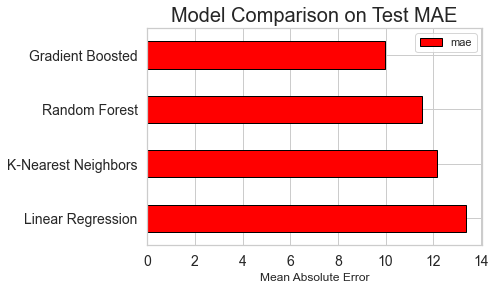

In [21]:
plt.figure(figsize = (8, 6))

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Random Forest', 'Gradient Boosted', 'K-Nearest Neighbors'],
                                 'mae': [lr_mae, random_forest_mae, gradient_boosted_mae, knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel('')
plt.yticks(size = 14)
plt.xlabel('Mean Absolute Error')
plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20)

Depending on the run (the exact results change slighty each time), the gradient boosting regressor performs the best followed by the random forest. I have to admit that this is not the most fair comparison because we are using mostly the default hyperparameters. The random forest and gradient boosting methods are great for starting out because the performance is less dependent on the model settings. Nonetheless, from these results, we can conclude that machine learning is applicable because all the models significantly outperform the baseline!

From here, I am going to concentrate on optimizing the best model using hyperparamter tuning. Given the results here, I will concentrate on using the `GradientBoostingRegressor`. This is the Scikit-Learn implementation of Gradient Boosted Trees which has won many Kaggle competitions in the past few years.

# Model Optimization 

In machine learning, optimizing a model means finding the best set of hyperparameters for a particular problem. 

## Hyperparameters

First off, we need to understand what model hyperparameters are in contrast to model parameters :

* Model __hyperparameters__ are best thought of as settings for a machine learning algorithm that are tuned by the data scientist before training. Examples would be the number of trees in the random forest, or the number of neighbors used in K Nearest Neighbors Regression. 
* Model __parameters__ are what the model learns during training, such as the weights in the linear regression.

We as data scientists control a model by choosing the hyperparameters, and these choices can have a significant effect on the final performance of the model (although usually not as great of an effect as getting more data or engineering features). 

Tuning the model hyperparameters controls the balance of under vs over fitting in a model. We can try to correct for under-fitting by making a more complex model, such as using more trees in a random forest. A model that underfits has high bias, and occurs when our model does not have enough capacity (degrees of freedom) to learn the relationship between the features and the target. We can try to correct for overfitting by limiting the complexity of the model and applying regularization. This might mean decreasing the degree of a polynomial regression. A model that overfits has high variance and in effect has memorized the training set. Both underfitting and overfitting lead to poor generalization performance on the test set. 

The problem with choosing the hyperparameters is that no set will work best across all problems. Therefore, for every new dataset, we have to find the best settings.

## Hyperparameter Tuning with Random Search and Cross Validation

We can choose the best hyperparameters for a model through random search and cross validation. 

* Random search refers to the method in which we choose hyperparameters to evaluate: we define a range of options, and then randomly select combinations to try. This is in contrast to grid search which evaluates every single combination we specify. Generally, random search is better when we have limited knowledge of the best model hyperparameters.
* Cross validation is the method used to assess the performance of the hyperparameters. Rather than splitting the training set up into separate training and validation sets which reduces the amount of training data we can use, we use K-Fold Cross Validation. This means dividing the training data into K folds, and then going through an iterative process where we first train on K-1 of the folds and then evaluate performance on the kth fold. We repeat this process K times so eventually we will have tested on every example in the training data with the key that each iteration we are testing on data that we __did not train on__.  At the end of K-fold cross validation, we take the average error on each of the K iterations as the final performance measure and then train the model on all the training data at once. The performance we record is then used to compare different combinations of hyperparameters. 

Here we will implement random search with cross validation to select the optimal hyperparameters for the gradient boosting regressor. We first define a grid then peform an iterative process of: randomly sample a set of hyperparameters from the grid, evaluate the hyperparameters using 4-fold cross-validation, and then select the hyperparameters with the best performance. 

Of course we don't actually do this iteration ourselves, we let Scikit-Learn and `RandomizedSearchCV` do the process for us! 

In [26]:
# defining parameter range 
param_grid = {"n_estimators": np.arange(250, 1000),
              "max_depth": np.arange(2, 10),
              "min_samples_leaf": np.arange(2, 10),
              "min_samples_split": np.arange(2, 10)}
  
random_cv = RandomizedSearchCV(GradientBoostingRegressor(random_state = 42), param_grid,
                               verbose = 3, cv = 3, n_jobs = -1, random_state = 42) 
  
# fitting the model
random_cv.fit(X, y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.3min finished


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_leaf': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262,
       263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 27...
       913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925,
       926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938,
       939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951,
       952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964,
       965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977,
       978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 

Scikit-learn uses the negative mean absolute error for evaluation because it wants a metric to maximize. Therefore, a better score will be closer to 0. We can get the results of the randomized search into a dataframe, and sort the values by performance.

In [27]:
random_cv.best_estimator_

GradientBoostingRegressor(max_depth=4, min_samples_leaf=4, min_samples_split=5,
                          n_estimators=268, random_state=42)

In [28]:
random_cv.best_score_

0.8018696924306278

In [29]:
gradient_boosted = GradientBoostingRegressor(**random_cv.best_params_)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 9.5103


# Evaluate Final Model on the Test Set

We will use the best model from hyperparameter tuning to make predictions on the testing set. Remember, our model has never seen the test set before, so this performance should be a good indicator of how the model would perform if deployed in the real world. 

For comparison, we can also look at the performance of the default model. The code below creates the final model, trains it (with timing), and evaluates on the test set. 

In [30]:
# Default model
default_model = GradientBoostingRegressor(random_state = 42)

# Select the best model
final_model = gradient_boosted

final_model

GradientBoostingRegressor(max_depth=4, min_samples_leaf=4, min_samples_split=5,
                          n_estimators=268)

In [31]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

3.13 s ± 239 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [32]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

10.8 s ± 311 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [33]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_pred))

Default model performance on the test set: MAE = 9.9880.
Final model performance on the test set:   MAE = 9.5075.


The final model does out-perform the baseline model, but at the cost of significantly increased running time (it's about 3 times slower on my machine). Machine learning is often a field of tradeoffs: bias vs variance, acccuracy vs interpretability, accuracy vs running time, and the final decision of which model to use depends on the situation. Here, the increase in run time is not an impediment, because while the relative difference is large, the absolute magnitude of the training time is not significant. In a different situation, the balance might not be the same so we would need to consider what we are optimizing for and the limitations we have to work with. 

To get a sense of the predictions, we can plot the distribution of true values on the test set and the predicted values on the test set. 

Text(0.5, 1.0, 'Test Values and Predictions')

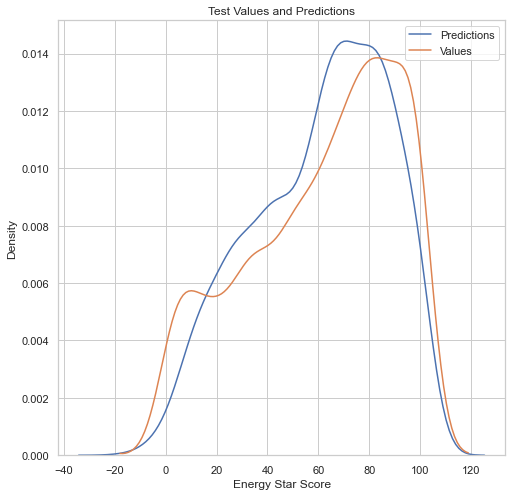

In [36]:
plt.figure(figsize = (8, 8))

# Density plot of the final predictions and the test values
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.xlabel('Energy Star Score')
plt.ylabel('Density')
plt.title('Test Values and Predictions')

The distribution looks to be nearly the same although the density of the predicted values is closer to the median of the test values rather than to the actual peak at 100. It appears the model might be less accurate at predicting the extreme values and instead predicts values closer to the median. 

Another diagnostic plot is a histogram of the residuals. Ideally, we would hope that the residuals are normally distributed, meaning that the model is wrong the same amount in both directions (high and low). 

Text(0.5, 1.0, 'Distribution of Residuals')

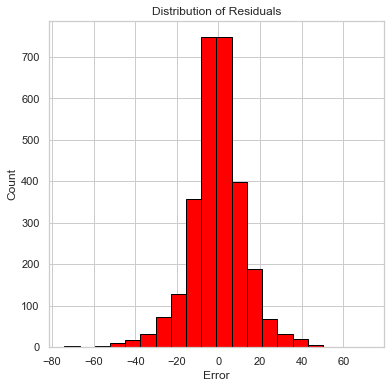

In [37]:
plt.figure(figsize = (6, 6))

# Calculate the residuals 
residuals = final_pred - y_test

# Plot the residuals in a histogram
plt.hist(residuals, color = 'red', bins = 20, edgecolor = 'black')
plt.xlabel('Error')
plt.ylabel('Count')
plt.title('Distribution of Residuals')

The residuals are close to normally disributed, with a few noticeable outliers on the low end. These indicate errors where the model estimate was far below that of the true value. 

# Conclusions

In this notebook, we covered crucial concepts in the machine learning pipeline:

* Imputing missing values
* Evaluating and comparing several machine learning methods
* Hyperparameter tuning a machine learning model using random search and cross validation
* Evaluating the best model on the testing set

The results showed us that machine learning is applicable to our problem, with the final model able to the predict the Energy Star Score of a building to within 9.5 points. We also saw that hyperparamter tuning was able to improve the performance of the model although at a considerable cost in terms of time invested. This is a good reminder that proper feature engineering and gathering more data (if possible!) has a much larger pay-off than fine-tuning the model. We also observed the trade-off in run-time versus accuracy, which is one of many considerations we have to take into account when designing machine learning models. 

We know our model is accurate, but do we know why it makes the predictions it does? The next step in the machine learning process is crucial: trying to understand how the model makes predictions. Achieveing high accuracy is great, but it would also be helpful if we could figure out why the model is able to predict accurately so we could use this information to better understand the problem. For example, what features does the model rely on to infer the Energy Star Score? Is it possible to use this model for feature selection and implement a simpler model that is more interpretable? 

In the final notebook, we will try to answer these questions and draw final conclusions from the project!